In [38]:
import numpy as np
from scipy import linalg as la
import matplotlib.pyplot as plt
%matplotlib inline

/Users/emilyschlafly/anaconda/envs/py3k/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/Users/emilyschlafly/anaconda/envs/py3k/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


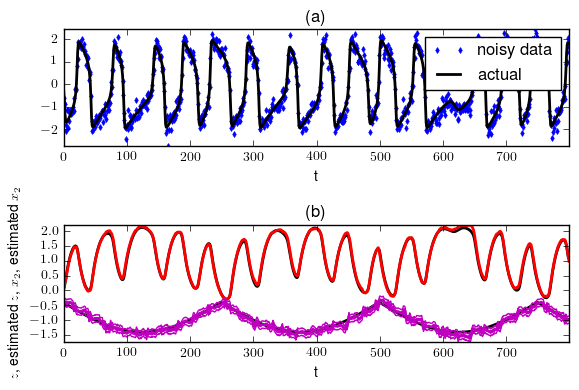

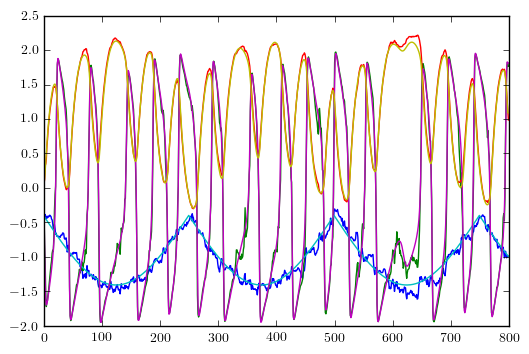

In [518]:
# voss.m function translated from schiff, ch5, p.110
dims_params = 1 # dq
dims_augmented_state, dims_observations = dims_params+2, 1 # dx, dy
fct = vossFNfct
obsfct = vossFNobsfct
num_samples = 800
dt_sample = 0.2
dt_integrate = dt_sample
steps_per_sample = int(dt_sample//dt_integrate)

# Preallocate arrays
x0 = np.zeros((2,num_samples)) # true trajectory
xhat = np.zeros((dims_augmented_state,num_samples)) # estimated trajectory
Pxx = np.zeros((dims_augmented_state,dims_augmented_state,num_samples)) # covariance in x
errors = np.zeros((dims_augmented_state, num_samples))
Ks = np.zeros((dims_augmented_state,dims_observations,num_samples))

# Initial conditions
x0[:,0] = [0.,0.]

# External input current, estimated as parameter p later
Iext = np.arange(1,num_samples+1)/250.*2*np.pi
Iext = -0.4 - 1.01*(np.abs(np.sin(Iext/2.)))

# RuKu4 integrator
def ruku4(x0,dt_integrate,Iext):
    for i in range(steps_per_sample):
        k1 = dt_integrate*vossFNint(x0,Iext)
        k2 = dt_integrate*vossFNint(x0+k1/2,Iext)
        k3 = dt_integrate*vossFNint(x0+k2/2,Iext)
        k4 = dt_integrate*vossFNint(x0+k3,Iext)
        x0 += k1/6. + k2/3. + k3/3. + k4/6.
    return x0

for n in range(num_samples-1):
    x_temp = x0[:,n]
    x0[:,n+1] = ruku4(x_temp,dt_integrate,Iext[n])
        
augmented_state = np.vstack((Iext,x0))
xhat[:,0] = augmented_state[:,0]

# Covariances
process_noise = 0.015
observation_noise = 0.2*0.2*np.var(vossFNobsfct(augmented_state))*np.eye(dims_observations)

noisy_data = obsfct(augmented_state) + np.matmul(la.sqrtm(observation_noise),
                                   np.random.randn(dims_observations,num_samples))
Pxx[:,:,0] = la.block_diag(process_noise,observation_noise,observation_noise)

# Main loop for recursive estimation
for k in range(1,num_samples):
    xhat[:,k],Pxx[:,:,k],Ks[:,:,k] = voss_unscented_transform(xhat[:,k-1],Pxx[:,:,k-1],noisy_data[:,k],
                                         fct,obsfct,dims_params,dims_augmented_state,
                                         dims_observations, observation_noise)
    Pxx[0,0,k] = process_noise
    errors[:,k] = np.sqrt(np.diag(Pxx[:,:,k]))
    
# Results
chisq = np.mean((augmented_state[0,:]-xhat[0,:])**2 + (augmented_state[1,:]-xhat[1,:])**2 + 
               (augmented_state[2,:] - xhat[2,:])**2) # this can probably be simplified to mean((augmented_state - xhat)**2)
est = np.transpose(xhat[0:dims_params-1,-1])
error = np.transpose(errors[0:dims_params-1,-1])
meanest = np.mean(np.transpose(xhat[:dims_params-1,:]))
meanerror = np.mean(np.transpose(errors[:dims_params,:]))

# Plotting
plt.rc('text', usetex=True)
plt.subplot(2,1,1)
plt.plot(noisy_data[0,:],'bd',markeredgecolor='blue', mfc='blue',ms=3,label='noisy data');
plt.plot(augmented_state[dims_params,:],'k',linewidth=2,label='actual'); 
plt.xlabel('t');
plt.legend();
plt.axis('tight')
plt.title('(a)')
plt.subplot(2,1,2)
plt.plot(augmented_state[dims_params+1,:],'k',lw=2,label='decay variable');
plt.plot(xhat[dims_params+1,:],'r',lw=2); 
plt.plot(augmented_state[0,:],'k',lw=2, label='external current');
for i in range(dims_params):
    plt.plot(xhat[i,:],'m',linewidth=2)
    plt.plot(xhat[i,:] + errors[i,:],'m')
    plt.plot(xhat[i,:] - errors[i,:],'m')
plt.xlabel('t')
plt.ylabel('$z$, estimated $z$, $x_2$, estimated $x_2$')
plt.axis('tight')
plt.title('(b)')
plt.tight_layout()
plt.figure()
plt.plot(xhat.T)
plt.plot(augmented_state.T)
plt.show()

In [517]:
# vossut function translated from matlab code in Schiff, ch 5, p.110

def voss_unscented_transform(xhat,Pxx,noisy_data,fct,obsfct,dims_params,dims_augmented_state,
           dims_observations,observation_noise):
    
    Pxx = symmetrize(Pxx)
    
    Xa = generate_sigma_points(xhat,Pxx)
    X = fct(dims_params,Xa)
    Y = obsfct(X).reshape(1,-1)
    
    Pxx = symmetrize(covariance(X,X))
    Pyy = covariance(Y,Y) + observation_noise
    Pxy = covariance(X,Y)
        
    K = np.matmul(Pxy,la.inv(Pyy))
    xhat = np.mean(X,1) + np.matmul(K,(noisy_data - np.mean(Y,1)))

    Pxx = symmetrize(Pxx - np.matmul(K,Pxy.T))
    
    return xhat,Pxx,K

def covariance(X,Y):
    '''Calculates biased covariance (or cross covariance) of array-like X and Y'''
    num_samples = len(X[0,:])
    X_centered = mean_center(np.array(X))
    Y_centered = mean_center(np.array(Y))
    return np.matmul(X_centered,Y_centered.T/num_samples)

def mean_center(X):
    '''Centers the mean of rows of X (array-like) around 0.'''
    return np.array([x - np.mean(x) for x in X])

def symmetrize(A):
    '''Numerical safety'''
    return (A + np.transpose(A)) / 2

def generate_sigma_points(xhat,Pxx):
    '''Why have the extra terms from the Cholesky decomp?? Why not just use sigma in each direction?'''
    dims = len(xhat)
    num_sigma_points = 2*dims
    Pxx = symmetrize(Pxx)
    xsigma = la.cholesky(dims*Pxx,True)
    Xa = np.hstack((xsigma,-xsigma))
    for i in range(num_sigma_points):
        Xa[:,i]+=xhat
    return Xa


In [436]:
# Test: mean_center 
A = np.random.randn(3,4)
A0 = mean_center(A)
assert np.allclose(np.mean(A0,1),0)

# Test: symmetrize
A = np.random.randn(3,3)
assert (symmetrize(A) == np.transpose(symmetrize(A))).all()

# Test: covariance
A = np.array(np.random.randn(2,10))
B = np.array(np.random.randn(1,10))
assert np.allclose(covariance(A,A),np.cov(A,bias=True))
print(covariance(A,B))
# assert np.allclose(covariance(A,B),np.cov(A,B,bias=True))

# Test: generate_sigma_points


[[ 0.09752688]
 [ 0.12391701]]


In [254]:
# A = np.random.randn(2,30)
A = 2*np.ones((2,6))
A[:,0::2] = 0.
print(A)
Pxx = covariance(A,A)
print(Pxx)
xhat = np.array([[1.], [1.]])
print('sigma points:\n',generate_sigma_points(xhat[:,0],Pxx))

[[ 0.  2.  0.  2.  0.  2.]
 [ 0.  2.  0.  2.  0.  2.]]
[[ 1.  1.]
 [ 1.  1.]]
sigma points:
 [[ 2.41421356  2.41421356 -0.41421356 -0.41421356]
 [ 1.          1.00000002  1.          0.99999998]]


In [491]:
def vossFNint(state,input_current):
    '''Check this... Returns derivative of voltage (state[0]) and recovery (state[1]) variables'''
    a, b, c = 0.7, 0.8, 3.
    v, w = state
    input_current = input_current.reshape(v.shape)
    output = np.array([c*(w+v-v**3/3+input_current),
                     -(v-a+b*w)/c]);
#     print('v:',v.shape,'w',w.shape,'input_current',input_current.shape, 'output:',output.shape)
    return output

def vossFNobsfct(state):
    return state[1,:].reshape(1,len(state[1,:]))

def vossFNfct(dims_params, augmented_state):
    Iext = augmented_state[:dims_params,:]
    observations = augmented_state[dims_params:,:]
#     print('observations:',observations.shape,'Iext:',Iext.shape)
    observations = ruku4(observations,dt_integrate,Iext)
#     print('observations:',observations.shape)
    return np.vstack((Iext,observations))
    

In [478]:
Iext = augmented_state[:dims_params,:]
vossFNint(augmented_state[1:,:],Iext).shape

v: (10,) w (10,) input_current (1, 10) output: (2,)


(2,)

In [488]:
print(np.reshape(Iext, b.shape))
print(Iext.shape)

[-0.4126917  -0.4253814  -0.43806708 -0.45074676 -0.46341842 -0.47608007
 -0.48872971 -0.50136533 -0.51398495 -0.52658657]
(1, 10)
